In [1]:
!pip install langchain_openai langgraph langsmith langchain_community "httpx==0.27.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.32
    Uninstalling langchain-core-0.3.32:
      Successfully uninstalled langchain-core-0.3.32


In [2]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"pr-vengeful-questionnaire-11"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2"  ## 랭스미스 API 키 입력

os.environ["OPENAI_API_KEY"] = "sk"
os.environ["TAVILY_API_KEY"] = "tvly"

In [3]:
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)] # 도구 정의, max_results=1은 검색 결과를 하나만 반환하겠다는 의미입니다
tool_node = ToolNode(tools) # 도구를 사용하는 작업 노드를 정의, 이 노드는 그래프에서 도구 실행을 처리합니다.

llm = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]: # 대화 상태(MessagesState)를 기반으로 워크플로우를 종료할지, 도구를 호출할지 결정
    messages = state['messages']
    last_message = messages[-1]
    if "tool_calls" not in last_message.additional_kwargs:
        return "__end__"  # 마지막 메시지에 tool_calls이 없으면 대화를 종료("__end__")
    else:
        return "tools" # 그렇지 않다면 계속 진행

def call_model(state: MessagesState): # 모델 호출
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}


In [4]:
workflow = StateGraph(MessagesState) # 워크플로우 초기화

workflow.add_node("agent", call_model) # 노드 추가
workflow.add_node("tools", tool_node) # 노드 추가

workflow.add_edge("__start__", "agent") # 엣지 추가
workflow.add_conditional_edges(
    "agent",
    should_continue,
) # 조건부 흐름 추가
workflow.add_edge("tools", 'agent') # 도구 실행 후 다시 언어 모델 호출
app = workflow.compile() # 워크플로우 컴파일(실행 가능한 형태로 변환)


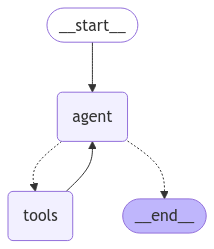

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [6]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="가볍게 읽을 수 있는 소설책을 추천해주세요")]},
    config={"configurable": {"thread_id": 42}} # 워크플로우를 구분하기 위한 고유한 스레드 ID를 할당
)
final_state["messages"][-1].content # 최종 상태에서 답변 출력

'가볍게 읽을 수 있는 소설책으로는 다음과 같은 작품들이 있습니다:\n\n1. **"노르웨이의 숲"** - 무라카미 하루키\n   - 청춘의 사랑과 상실을 다룬 감성적인 소설로, 무라카미 하루키의 대표작 중 하나입니다.\n\n2. **"연금술사"** - 파울로 코엘료\n   - 자신의 꿈을 찾아 떠나는 소년의 모험을 그린 철학적인 소설로, 많은 이들에게 영감을 주는 작품입니다.\n\n3. **"어린 왕자"** - 앙투안 드 생텍쥐페리\n   - 어린 왕자와의 만남을 통해 삶의 중요한 가치를 되새기게 하는 동화 같은 소설입니다.\n\n4. **"달과 6펜스"** - 서머싯 몸\n   - 예술과 삶의 의미를 탐구하는 소설로, 가볍게 읽으면서도 깊은 생각을 하게 만드는 작품입니다.\n\n5. **"모모"** - 미하엘 엔데\n   - 시간의 소중함을 일깨워주는 판타지 소설로, 어린이와 어른 모두에게 사랑받는 이야기입니다.\n\n이 책들은 비교적 짧고 쉽게 읽을 수 있으면서도, 깊이 있는 메시지를 전달하는 작품들입니다.'